In [1]:
import autograd.numpy as np

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import random
import matplotlib.pyplot as plt
from autograd import grad
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image
from scipy.signal import find_peaks
from sklearn.preprocessing import MinMaxScaler

from numpy.fft import *
import matplotlib.style as style 
style.use('ggplot')

# import function flattening module from autograd
from autograd.misc.flatten import flatten_func

## Step 1: Extract data and denoise

Extract a sample set to use for training data, and denoise it with a threshold filter.

In [2]:
data = np.loadtxt('../data/test.csv',delimiter = ' ')[0]

In [3]:
#function to filter out frequencies in signal that are above the threshold
def filter_signal(signal, threshold=5e3):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

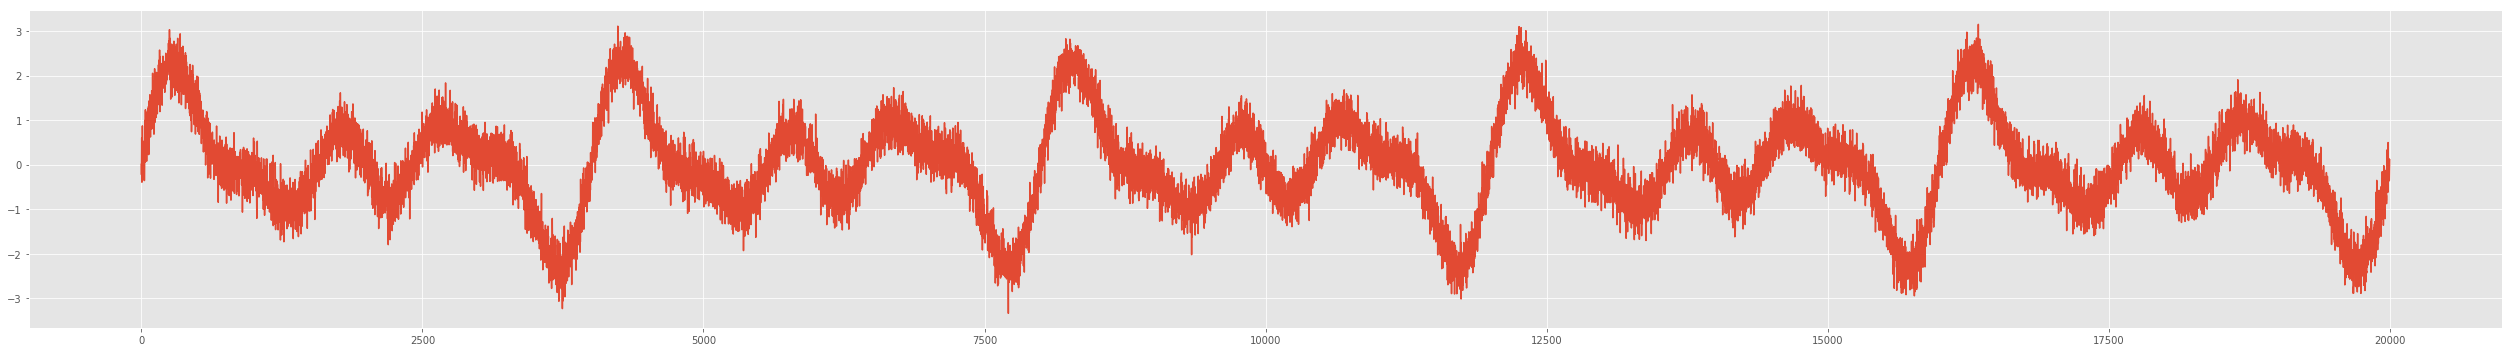

In [4]:
#Plot of a clean window of data
clean_data = data[:20000]

plt.figure(figsize=(35,5))
plt.plot(clean_data)
plt.show()

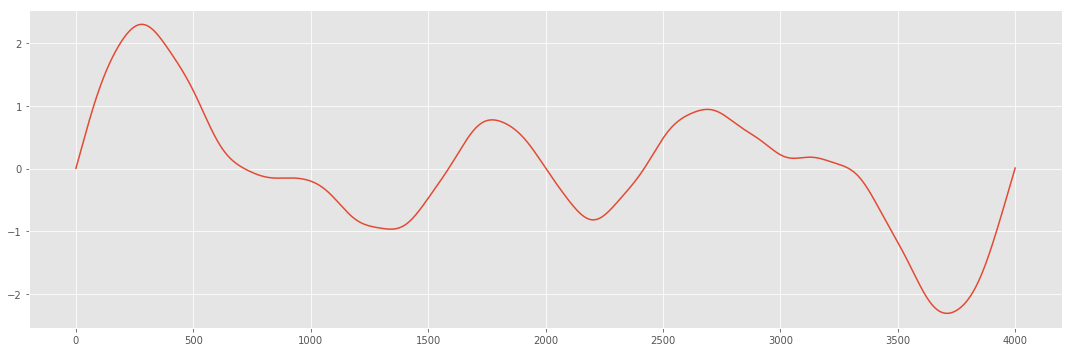

In [22]:
# Plot cleaned data by filtering out all frequencies greater than the threshold
X = filter_signal(clean_data)[:4001]

plt.figure(figsize=(15,5))
plt.plot(X)
plt.show()

## Step 2: Create training data

The approach here is to produce input & output data for supervised learning.
The clean signal for 5 cycles is the input data (variable X), and the output data (variable Y) is a counter for the number of cycles that starts at zero and increases linearly to one at the end of the first cycle and continues to increase linearly with the number of cycles.

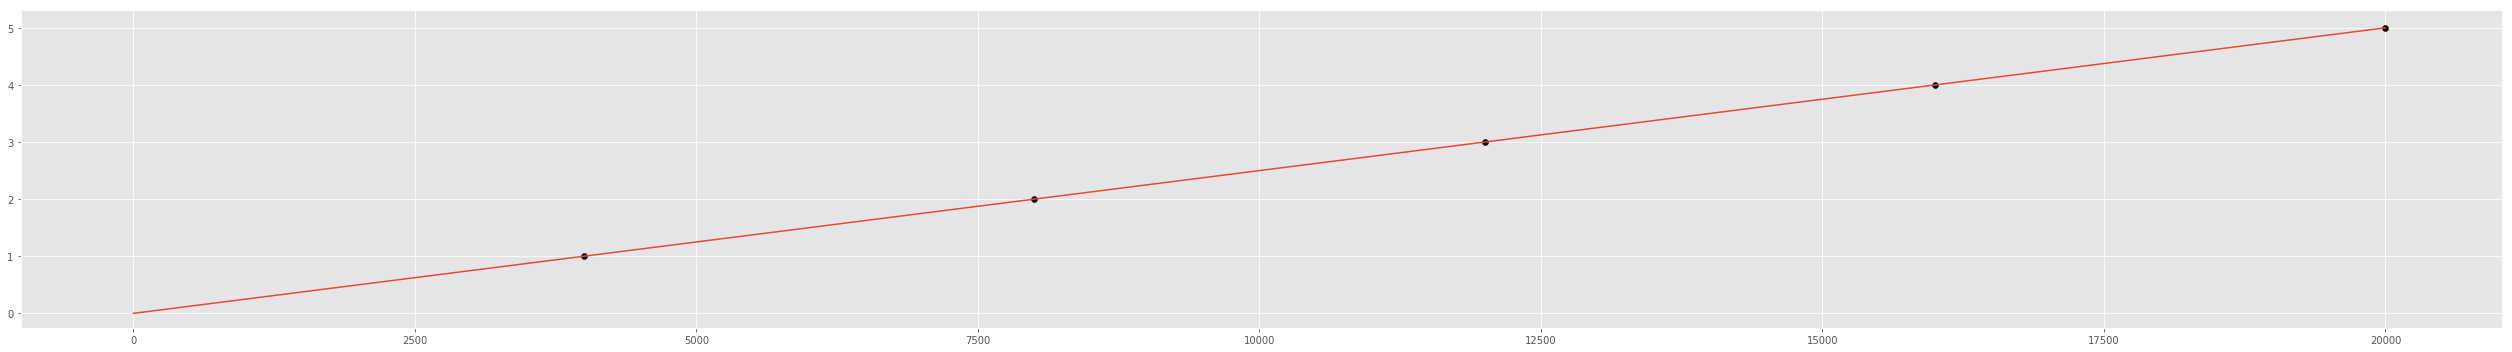

In [6]:
scaler = MinMaxScaler(feature_range=(0, 5)) #init scaler, scales between 0 and 5
Y = scaler.fit_transform(np.asarray([i for i in range(len(clean_data)+1)]).reshape(-1,1)) #generate supervised output data

#plot the output with points for ints - represents the end of a cycle and an increment in count
plt.figure(figsize=(35,5))
plt.plot(Y)
plt.scatter([4000,4000*2,4000*3,4000*4,4000*5],[1,2,3,4,5],color='Black')
plt.show()

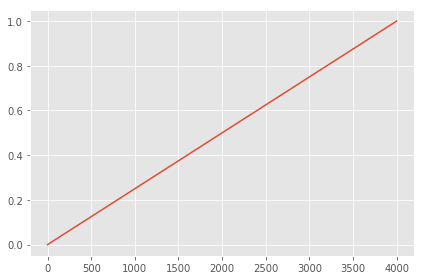

In [7]:
Y = Y[:4001]
plt.plot(Y)

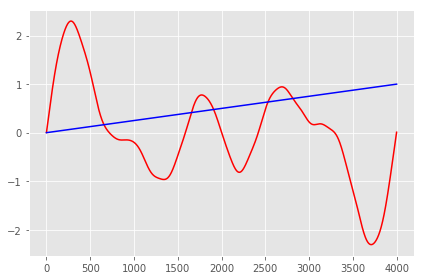

In [26]:
plt.plot(X, c= 'red')
plt.plot(Y, c= 'blue')

## Step 3: Define model

𝑦(𝑡)=𝐴sin(Ω𝑡)cos(𝜙)+𝐴cos(Ω𝑡)sin(𝜙) 

In [27]:
# y_new[:,0].shape

In [28]:
x_new = X.copy()
# y_new = Y[1:].copy()
y_new = Y.copy()

# y_new = y_new[:,0]
x_new = np.array([x_new])
y_new = y_new.T

In [29]:
print(x_new.shape)
print(y_new.shape)

(1, 4001)
(1, 4001)


In [165]:
# plt.plot(x_new[0])
# plt.plot(y_new[0])
w = np.array([0.1*np.random.randn(1),0.1*np.random.randn(2,10),0.1*np.random.randn(2,10)])
w[0][0]

-0.10154777555946702

In [228]:
def feature_transforms(x,w):
#     print("feature transforms")
#     print("shape of w0",w[0].shape)
#     print("shape of w1",w[1].shape)
#     print("shape of x.T",x.T.shape)
    # calculate feature transform
#     f = np.sin(w[0]+np.dot(x.T,w[1:]))
#     f = w[0]*np.dot(x.T,w[1:])
    f = w[0]*np.dot(x.T,w[1:])
#     f = w[0]*f
#     print("shape of f:",f.shape)
    return f.T

def model(x,w): 

    # feature transformation 
    f = feature_transforms(x,w[0])

    # compute linear combination and return
    
#     a = w[1][0] + np.dot(x.T,w[1][1:])
    a = w[1][0] + np.dot(x.T,w[1][1:])
#     a = w[1][0] + w[1][1]*f.T
    return a.T

# least squares cost
def least_squares(w):
    cost = np.sum((model(x_new,w) - y_new)**2)
    #print(fusion_rule(x,w))
    return cost/float(np.size(y_new))
#     return cost

#gradient descent optimizer
def gradient_descent(g,alpha,max_its,w): 
    # compute gradient module using autograd
    gradient = grad(g)

    # run the gradient descent loop
    weight_history = [w] # weight history container
    cost_history = [g(w)] # cost function history container
    for k in range(max_its):
        # evaluate the gradient
        grad_eval = gradient(w)

        # take gradient descent step
        w = w - alpha*grad_eval
        
        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
    return weight_history,cost_history

In [230]:
w = np.array([0.1*np.random.randn(2,1),0.1*np.random.randn(2,1)])
# w = np.array([0.1*np.random.randn(2,1),0.1*np.random.randn(2,1)])
# w = np.array([0.1*np.random.randn(1),0.1*np.random.randn(2,1),0.1*np.random.randn(2,1)])
g = least_squares;max_its = 1000;alpha_choice = 1e-4; 
weight_history_1,cost_history_1 = gradient_descent(g,alpha_choice,max_its,w)

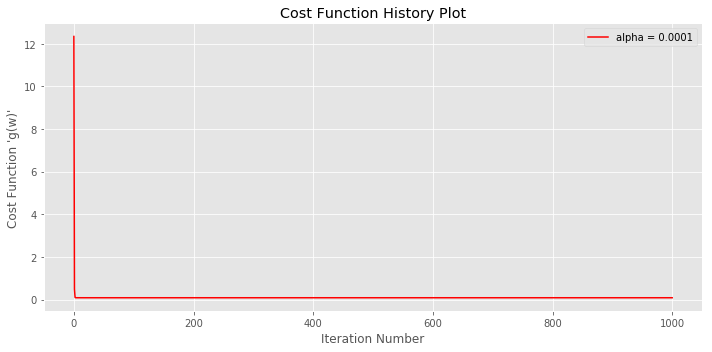

In [220]:
fig = plt.figure(figsize=(10,5))
plt.plot(range(len(cost_history_1)),cost_history_1,c='red',label='alpha = '+str(alpha_choice))
plt.legend(loc='upper right')
plt.title("Cost Function History Plot")
plt.xlabel("Iteration Number")
plt.ylabel("Cost Function 'g(w)'")
plt.show()

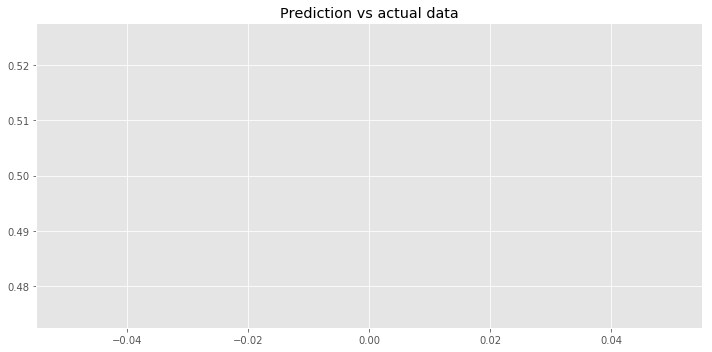

In [221]:
w1 = weight_history_1[-1]
mywave= model(x_new,w1)

fig = plt.figure(figsize=(10,5))

# plt.scatter(y_new,x_new, c='blue', label = 'debt data')
#plt.scatter(x_new,mywave,c='red',label='prediction line')
# plt.plot(y_new[0],c='red')
plt.plot(mywave[0],c="green")

plt.title("Prediction vs actual data")
plt.show()

In [222]:
mywave

array([[0.5]])

In [231]:
w.shape

(2, 2, 1)